In [89]:
from math import pi
from copy import copy
import numpy as np
from scipy.special import erfc

import matplotlib.pyplot as plt
%matplotlib widget

In [90]:

def fit_XS(E, el, a):
    E  = E.reshape(-1,1)
    el = el.reshape(1,-1)
    a = a.reshape(1,-1)
    XS_G = a/((E - el)**2 + 1)
    XS = np.sum(XS_G, axis=1)
    XS_G_tuple = tuple([XS_G[:,g] for g in range(XS_G.shape[1])])
    return XS, *XS_G_tuple

def transmission(xs, thicc):
    return np.exp(-xs*thicc)

def sample(E, el, a,
           thicc, N_0_true, N_B_true):

    # Getting Transmission:
    XS = fit_XS(E, el, a)[0]
    T_true = np.exp(-XS*thicc)
    N_G_true = N_0_true * T_true
    
    # Experimental Data:
    N_G_exp = N_G_true + np.sqrt(N_G_true)*np.random.randn(E.size)
    N_B_exp = N_B_true + np.sqrt(N_B_true)*np.random.randn(E.size)
    N_C_exp = N_G_exp + N_B_exp
    N_N_exp = N_C_exp - N_B_true
    T_exp   = N_N_exp / N_0_true

    # Estimate Standard Deviation:
    N_C_std = np.sqrt(N_C_exp)
    T_std   = N_C_std / N_0_true

    # Return Everything:
    return T_true, T_exp, T_std

def Chi2(XS_exp, XS_exp_sd, XS_fit):
    chi2 = np.sum((XS_exp - XS_fit)**2 / XS_exp_sd**2)
    chi2_bar = chi2 / (XS_exp.size - 1)
    return chi2_bar

def logLikelihood_grad(E, P, EB:tuple, FreqT:float):
    '...'

    # Wigner Log Likelihoods:
    L0 = lambda x: pi/4*FreqT**2*x**2 - np.log(pi/2*FreqT**2*x)
    L1 = lambda x: pi/4*FreqT**2*x**2 - np.log(FreqT)
    L2 = lambda x: -np.log(pi/2*FreqT * erfc(np.sqrt(pi/4*FreqT**2) * x))

    # Wigner Log Likelihood Derivatives:
    DL0 = lambda x: pi/2*FreqT**2 * x - 1/x
    DL1 = lambda x: pi/2*FreqT**2 * x
    # DL2 = lambda x: FreqT * np.exp(-pi/4*FreqT**2 * x**2) * erfc(np.sqrt(pi/4*FreqT**2) * x)

    if len(E) != 2:
        raise NotImplementedError('This algorithm can currently only handle 2 energies.')
    
    # Derivatives with respect to energy:
    Q = 1.0 - P # Conjugate Probability
    dLL_dE = np.zeros((2,))
    dLL_dE[0] = P[0] * (  DL1(E[0]-EB[0]) -P[1]*DL0(E[1]-E[0]) -Q[1]*DL1(EB[1]-E[0]) )
    dLL_dE[1] = P[1] * ( -DL1(EB[1]-E[1]) +P[0]*DL0(E[1]-E[0]) +Q[0]*DL1(E[1]-EB[0]) )

    # Derivatives with respect to probability:
    dP =  np.ones((2,)) # Derivative of P
    dQ = -np.ones((2,)) # Derivative of Q
    dLL_dP = np.zeros((2,))
    dLL_dP[0] = dP[0]      * L1(E[0]-EB[0]) \
              + dP[0]*P[1] * L0(E[1]-E[0]) \
              + dP[0]*Q[1] * L1(EB[1]-E[0]) \
              + dQ[0]*P[1] * L1(E[1]-EB[0]) \
              + dQ[0]*Q[1] * L2(EB[1]-EB[0])
    dLL_dP[1] =      dP[1] * L1(EB[1]-E[1]) \
              + P[0]*dP[1] * L0(E[1]-E[0]) \
              + Q[0]*dP[1] * L1(E[1]-EB[0]) \
              + P[0]*dQ[1] * L1(EB[1]-E[0]) \
              + Q[0]*dQ[1] * L2(EB[1]-EB[0])

    # Just Log Likelihood:
    LL = P[0]      * L1(E[0]-EB[0]) \
       + Q[0]*P[1] * L1(E[1]-EB[0]) \
       + Q[0]*Q[1] * L2(EB[1]-EB[0]) \
       + P[0]*P[1] * L0(E[1]-E[0]) \
       + P[0]*Q[1] * L1(EB[1]-E[0]) \
       +      P[1] * L1(EB[1]-E[1])

    return LL, dLL_dE, dLL_dP

def Chi2_grad(P, el, a, E, T_exp, T_exp_std, thicc):
    '...'

    T_exp = T_exp.reshape(-1,1)
    T_exp_std = T_exp_std.reshape(-1,1)
    N = len(E)
    n = 4
    xs_fit_11, xs_fit_10, xs_fit_01 = fit_XS(E, el, a)

    def Chi2(T_fit):
        T_fit = T_fit.reshape(-1,1)
        Chi2 = np.sum(((T_fit-T_exp)/T_exp_std)**2, axis=0) / (N-n)
        return Chi2

    def dChi2_da(T_fit, xs_fits, a):
        T_fit = T_fit.reshape(-1,1)
        a = a.reshape(1,-1)
        dChi2_dT = 2*(T_fit - T_exp) / ((N-n) * T_exp_std**2)
        dT_dxs = -thicc * T_fit
        dxs_da = xs_fits / a
        dChi2_da = np.sum(dChi2_dT * dT_dxs * dxs_da, axis=0)
        return dChi2_da
    
    def dChi2_dE(E, T_fit, xs_fits, a, el):
        E = E.reshape(-1,1)
        T_fit = T_fit.reshape(-1,1)
        a = a.reshape(1,-1)
        el = el.reshape(1,-1)
        dChi2_dT = 2*(T_fit - T_exp) / ((N-n) * T_exp_std**2)
        dT_dxs = -thicc * T_fit
        dxs_dE = 2 * (E-el) * xs_fits**2 / a
        dChi2_dE = np.sum(dChi2_dT * dT_dxs * dxs_dE, axis=0)
        return dChi2_dE
    
    xs_fits_11 = np.concatenate((xs_fit_10.reshape(-1,1), xs_fit_01.reshape(-1,1)), axis=1)
    xs_fits_10 = np.concatenate((xs_fit_10.reshape(-1,1), np.zeros((N,1))), axis=1)
    xs_fits_01 = np.concatenate((np.zeros((N,1)), xs_fit_01.reshape(-1,1)), axis=1)
    xs_fits_00 = np.concatenate((np.zeros((N,1)), np.zeros((N,1))), axis=1)

    T_fit_11 = np.exp(-np.sum(xs_fits_11, axis=1)*thicc)
    T_fit_01 = np.exp(-np.sum(xs_fits_01, axis=1)*thicc)
    T_fit_10 = np.exp(-np.sum(xs_fits_10, axis=1)*thicc)
    T_fit_00 = np.exp(-np.sum(xs_fits_00, axis=1)*thicc)

    # Derivatives on Resonance Height:
    Q = 1.0 - P # Conjugate Probability
    dChi2_mean_da = P[0]*P[1] * dChi2_da(T_fit_11, xs_fits_11, a) \
                  + Q[0]*P[1] * dChi2_da(T_fit_01, xs_fits_01, a) \
                  + P[0]*Q[1] * dChi2_da(T_fit_10, xs_fits_10, a) \
                  + Q[0]*Q[1] * dChi2_da(T_fit_00, xs_fits_00, a)
    
    # Derivatives on Resonance Energy:
    dChi2_mean_dE = P[0]*P[1] * dChi2_dE(E, T_fit_11, xs_fits_11, a, el) \
                  + Q[0]*P[1] * dChi2_dE(E, T_fit_01, xs_fits_01, a, el) \
                  + P[0]*Q[1] * dChi2_dE(E, T_fit_10, xs_fits_10, a, el) \
                  + Q[0]*Q[1] * dChi2_dE(E, T_fit_00, xs_fits_00, a, el)
    
    # Derivatives on Probability of Truth:
    dP =  np.ones((2,)) # Derivative of P
    dQ = -np.ones((2,)) # Derivative of Q
    dChi2_mean_dP = np.array([dP[0]*P[1], P[0]*dP[1]]) * Chi2(T_fit_11) \
                  + np.array([dQ[0]*P[1], Q[0]*dP[1]]) * Chi2(T_fit_01) \
                  + np.array([dP[0]*Q[1], P[0]*dQ[1]]) * Chi2(T_fit_10) \
                  + np.array([dQ[0]*Q[1], Q[0]*dQ[1]]) * Chi2(T_fit_00)
    
    # Just Chi2:
    Chi2_mean = P[0]*P[1] * Chi2(T_fit_11) \
              + Q[0]*P[1] * Chi2(T_fit_01) \
              + P[0]*Q[1] * Chi2(T_fit_01) \
              + Q[0]*Q[1] * Chi2(T_fit_00)
    
    return Chi2_mean, dChi2_mean_da, dChi2_mean_dE, dChi2_mean_dP

In [91]:
def plot_resonances(E, T_true, T_exp, T_exp_std, T_fit, T_fit_A, T_fit_B, P, El,
                    t:int, fig_num:int=None):
    plt.figure(fig_num)
    plt.clf()
    plt.plot(E, T_true, '-b', label='$T_{true}$')
    plt.errorbar(E, T_exp, T_exp_std, fmt='.k', capsize=3.0, label='$T_{exp}$')
    plt.plot(E, T_fit, '-r', label='$T_{fit}$')
    plt.plot(E, T_fit_A, '--r', label='$T_{A}$; P='+f'{P[0]:.1%}')
    plt.plot(E, T_fit_B, '--r', label='$T_{B}$; P='+f'{P[1]:.1%}')
    plt.vlines(El, 0.0, 1.0, colors='r', linestyles=':')
    plt.grid()
    plt.title(f'Iteration {t}', fontsize=18)
    plt.xlabel('Energy', fontsize=16)
    plt.ylabel('Transmission', fontsize=16)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Simplified SLBW

$$\sigma(E) = \frac{a}{(E-E_\lambda)^2+b^2}$$
Let $b$ be constant

# Sampling Initial Data

In [92]:
N_points = 20

EB = (-5.0, 5.0)
E = np.linspace(EB[0], EB[1], N_points)

# True Parameters:
el_true = np.array([0.0])
a_true  = np.array([1.0])

# Initial Parameters:
el0 = np.array([-0.3, 0.3])
a0  = np.array([ 0.55, 0.55])
p0  = np.array([ 0.5, 0.5])

thicc = 0.7 # relative thickness of target
N_0 = 1e3 # number of neutrons on TOF target
N_B = 0.2 * N_0 # background fraction of neutrons

MLS = 5.0 # mean level spacing
freqT = 1.0 / MLS # mean level density

w = 1.0 # Weighting factor for Wigner Likelihood

print()
print(f'a0  = {a0}')
print(f'el0 = {el0}')
print(f'p0  = {p0}')


a0  = [0.55 0.55]
el0 = [-0.3  0.3]
p0  = [0.5 0.5]


In [93]:
T_true, T_exp, T_exp_std = sample(E, el_true, a_true, thicc, N_0, N_B)
XS_fit, XS_fit_A, XS_fit_B = fit_XS(E, el0, a0)
T_fit   = np.exp(-thicc*XS_fit  )
T_fit_A = np.exp(-thicc*XS_fit_A)
T_fit_B = np.exp(-thicc*XS_fit_B)

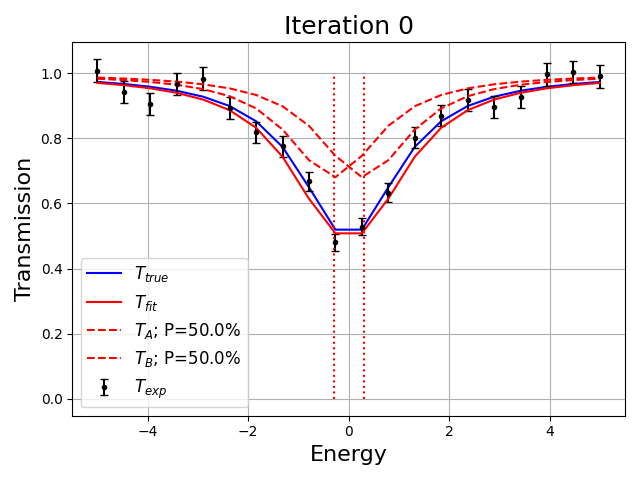

In [94]:
plot_resonances(E, T_true, T_exp, T_exp_std, T_fit, T_fit_A, T_fit_B,
                p0, el0,
                t=0, fig_num=1)

# plt.figure(1)
# plt.clf()
# plt.plot(E, T_true, '-b', label='$T_{true}$')
# plt.plot(E, T_fit, '--r', label='$T_{fit}$')
# plt.plot(E, T_fit_A, ':r', label='$T_{A}$')
# plt.plot(E, T_fit_B, ':r', label='$T_{B}$')
# plt.errorbar(E, T_exp, T_exp_std, fmt='.k', capsize=3.0, label='$T_{exp}$')
# plt.grid()
# plt.title('Starting Point', fontsize=18)
# plt.xlabel('Energy', fontsize=16)
# plt.ylabel('Transmission', fontsize=16)

# plt.legend(fontsize=12)
# plt.tight_layout()
# plt.show()

# ADAM

In [95]:
class ADAM:
    """
    ...
    """
    def __init__(self, lr:float=0.001, b1:float=0.9, b2:float=0.999, eps:float=1e-8, x0:float=0.0):
        """
        ...
        """
        self.b1  = b1
        self.b2  = b2
        self.eps = eps
        self.lr  = lr

        self.x = x0

        shape = x0.shape
        self.m = np.zeros(shape)
        self.v = np.zeros(shape)
        self.t = 0

    def iterate(self, dL_dw):
        """
        ...
        """
        self.t += 1

        # lim = 100000
        # dL_dw[dL_dw >  lim] =  lim
        # dL_dw[dL_dw < -lim] = -lim

        self.m = self.b1*self.m + (1-self.b1)*dL_dw
        self.v = self.b2*self.v + (1-self.b2)*dL_dw**2
        mh = self.m/(1-self.b1**self.t)
        vh = self.v/(1-self.b2**self.t)
        foo = mh/np.sqrt(vh+self.eps)
        self.x = self.x - self.lr*foo
        return self.x

# Gradient Descent and Plotting

iteration 0:
a  = [0.55 0.55]
el = [-0.3  0.3]
p  = [0.5 0.5]


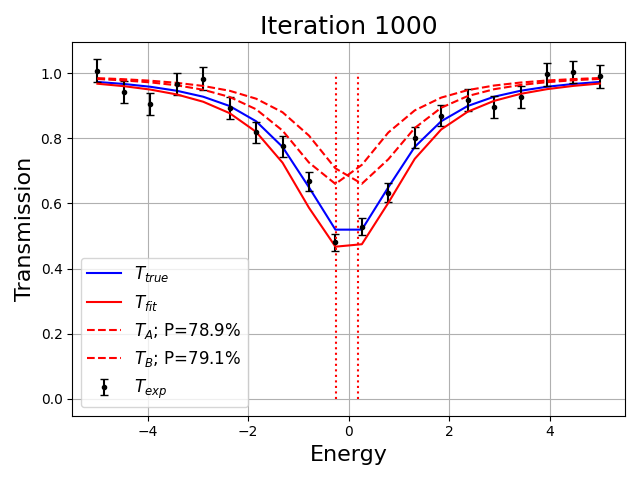

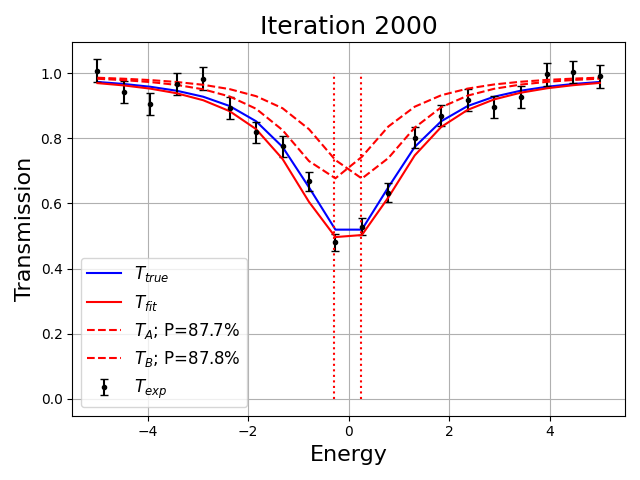

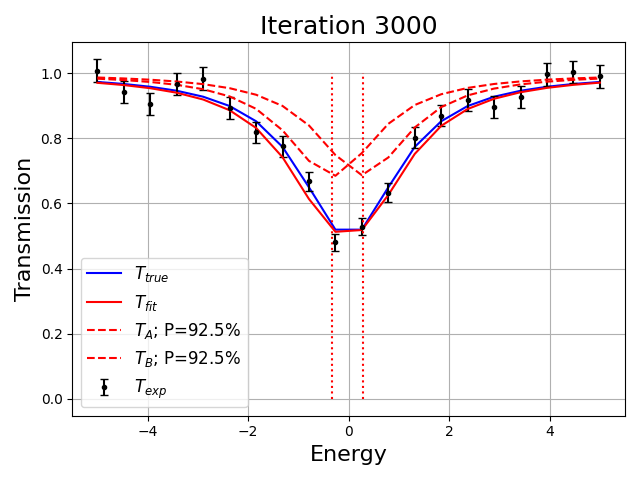

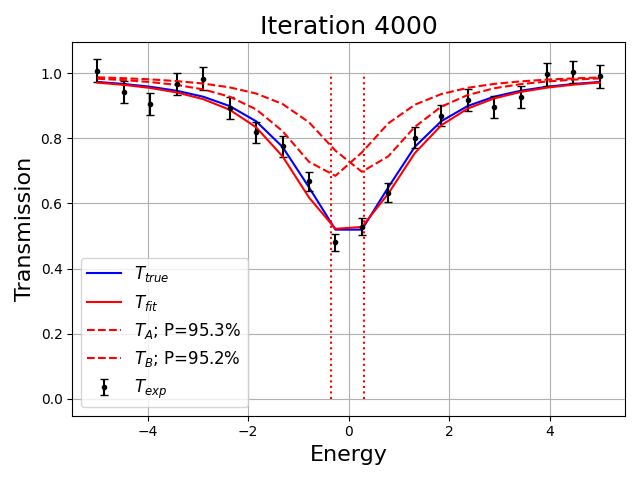

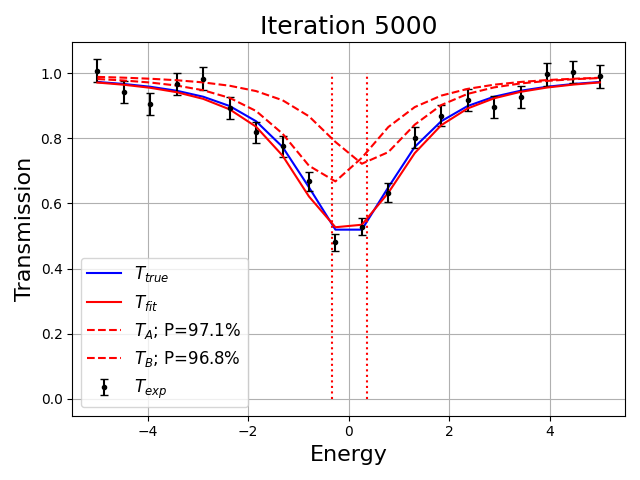

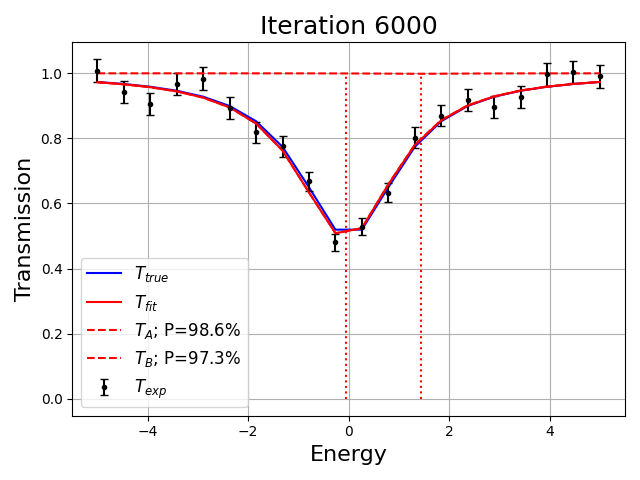

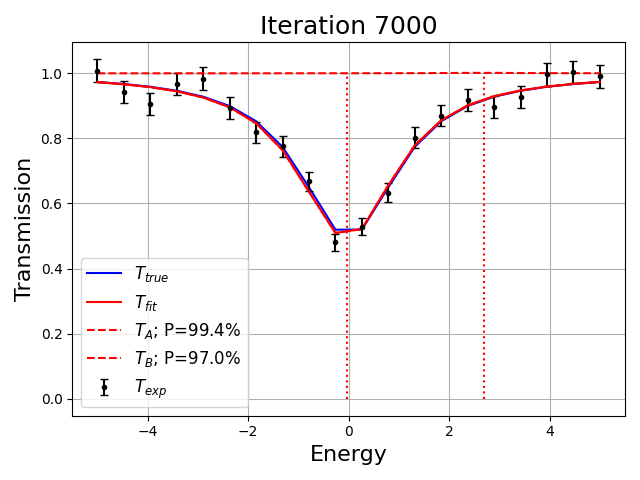

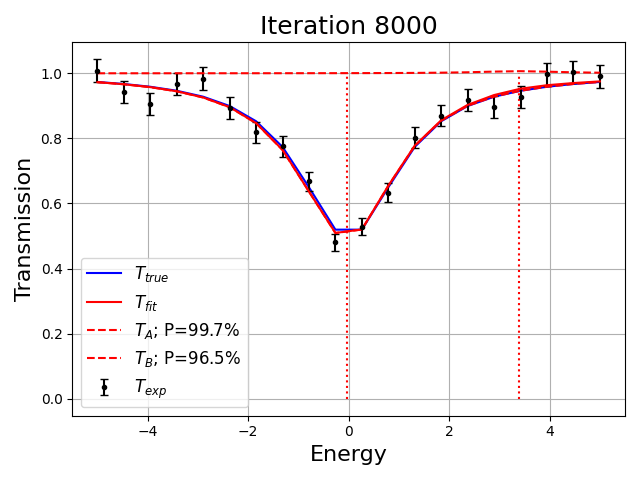

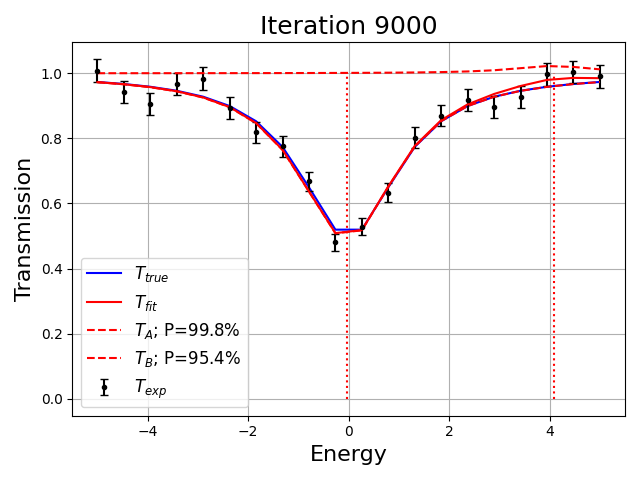

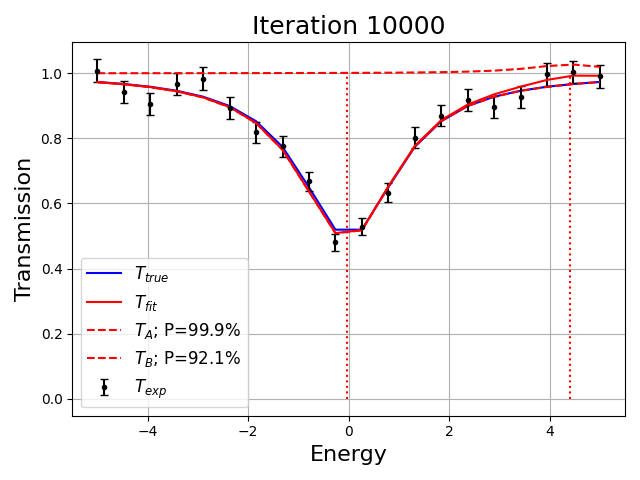

In [96]:
gd_a = ADAM(lr=0.001, b1=0.9, b2=0.999, eps=1e-8, x0=a0)
gd_E = ADAM(lr=0.001, b1=0.9, b2=0.999, eps=1e-8, x0=el0)
gd_P = ADAM(lr=0.001, b1=0.9, b2=0.999, eps=1e-8, x0=p0)

p  = copy(p0)
el = copy(el0)
a  = copy(a0)

print(f'iteration 0:')
print(f'a  = {a}')
print(f'el = {el}')
print(f'p  = {p}')

# plot = ResPlot(E, T_true, T_exp, T_exp_std, fig_num=42)

P  = []
El = []
A  = []
LL = []
Chi2 = []
F = []
for t in range(10000):

    ll, dLL_dE, dLL_dP = logLikelihood_grad(el, p, EB, freqT)
    LL.append(ll)
    chi2, dchi2_da, dchi2_dE, dchi2_dP = Chi2_grad(p, el, a, E, T_exp, T_exp_std, thicc)
    Chi2.append(chi2)
    f = ll + w*chi2
    F.append(f)

    # Objective Function Derivatives:
    dF_da = dchi2_da + w*0.0
    dF_dE = dchi2_dE + w*dLL_dE
    dF_dP = dchi2_dP + w*dLL_dP

    # Converting to a sigmoid to force (0,1) on P:
    s = np.log(p/(1-p))
    dF_dS = p*(1-p) * dF_dP

    a  = gd_a.iterate(dF_da)
    el = gd_E.iterate(dF_dE)
    s  = gd_P.iterate(dF_dS)
    p  = 1/(1+np.exp(-s))
    A.append(a)
    El.append(el)
    P.append(p)

    if (t+1) % 1000 == 0:
        # print()
        # print(f'iteration {t+1}:')
        # print(f'a  = {a}')
        # print(f'el = {el}')
        # print(f'p  = {p}')
        # print(f'f  = {f}')

        XS_fit, XS_fit_A, XS_fit_B = fit_XS(E, el, a)
        T_fit   = np.exp(-thicc*XS_fit  )
        T_fit_A = np.exp(-thicc*XS_fit_A)
        T_fit_B = np.exp(-thicc*XS_fit_B)
        # plot.update(T_fit, T_fit_A, T_fit_B, p, t+1)
        plot_resonances(E, T_true, T_exp, T_exp_std, T_fit, T_fit_A, T_fit_B,
                        p, el,
                        t+1, fig_num=t+1)